In [0]:
# Tensorboard visualization for pytorch in Google Colab
%%capture
!pip install tensorboardX
!pip install -q tf-nightly-2.0-preview
%load_ext tensorboard

In [0]:
import os
import torch
from torch import nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
from tensorboardX import SummaryWriter
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torchsummary import summary

In [3]:
# Cuda stuff
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device is " + str(device) + ".")

Device is cuda.


In [0]:
dataset = 'mnist'
img_size = 32
channels = 1
targets_size = 10
z_size = 100
lr = 0.0002
betas1 = 0.5

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # 3 x 64 x 64
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2),
        ) # 64 x 32 x 32
        
        self.conv1_targets = nn.Sequential(
            nn.Conv2d(in_channels=targets_size, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2),
        ) # 64 x 32 x 32
        
        
        # 128 x 32 x 32
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

        )
        
        # 256 x 16 x 16
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )
        
        # 512 x 8 x 8
  
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2),
        )
    
        # 1024 x 4 x 4
      
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, img, targets):
        x_img = self.conv1(img)
        x_targets = self.conv1_targets(targets)
        x = torch.cat((x_img, x_targets), 1)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        out = self.conv5(x)
        out = out.view(-1, 1)
        return out

In [0]:
class Discriminator_32(nn.Module):
    def __init__(self):
        super(Discriminator_32, self).__init__()
        # 3 x 32 x 32
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2),
        ) # 64 x 16 x 16
        
        self.conv1_targets = nn.Sequential(
            nn.Conv2d(in_channels=targets_size, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2),
        ) # 64 x 16 x 16
        
        
        # 128 x 16 x 16
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

        )
        
        # 256 x 8 x 8
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )
        
    
        # 512 x 4 x 4
      
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, img, targets):
        x_img = self.conv1(img)
        x_targets = self.conv1_targets(targets)
        x = torch.cat((x_img, x_targets), 1)
        x = self.conv2(x)
        x = self.conv3(x)
        out = self.conv4(x)
        out = out.view(-1, 1)
        return out

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        # z_size x 1 x 1        
        self.convt1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=z_size+targets_size, out_channels=1024, kernel_size = 4, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
        )
        
        # 1024 x 4 x 4
        self.convt2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size = 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        
        # 512 x 8 x 8
        self.convt3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size = 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        
        # 256 x 16 x 16
        self.convt4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size = 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        
        # 128 x 32 x 32
        self.convt5 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=channels, kernel_size = 4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )
        
        # 3 x 64 x 64
        
        
    def forward(self, z, targets):
        x = self.convt1(torch.cat((z, targets), 1))
        x = self.convt2(x)
        x = self.convt3(x)
        x = self.convt4(x)
        out = self.convt5(x)
        return out

In [0]:
class Generator_32(nn.Module):
    def __init__(self):
        super(Generator_32, self).__init__()
        
        # z_size x 1 x 1        
        self.convt1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=z_size+targets_size, out_channels=512, kernel_size = 4, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        
        # 512 x 4 x 4
        self.convt2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size = 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        
        # 256 x 8 x 8
        self.convt3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size = 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        
        # 128 x 16 x 16
        self.convt4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=channels, kernel_size = 4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )
        
        # 3 x 32 x 32
        
        
    def forward(self, z, targets):
        x = self.convt1(torch.cat((z, targets), 1))
        x = self.convt2(x)
        x = self.convt3(x)
        out = self.convt4(x)
        return out

In [9]:
# Download Celeb_A dataset from my Google Drive, extract to 'data'
from google.colab import drive
from zipfile import ZipFile
drive.mount('/content/gdrive')
!cp 'gdrive/My Drive/datasets/img_align_celeba.zip' .
zipfile = ZipFile('img_align_celeba.zip')
zipfile.extractall(path='./data')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
def load_data(batch_size, dataset=dataset):
    root = 'data/'  
    if dataset == 'celeba':
        trans = transforms.Compose([transforms.Resize(img_size), transforms.CenterCrop(img_size), transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
        train_set = dset.ImageFolder(root=root, transform=trans)
    elif dataset == 'mnist':
        trans = transforms.Compose([transforms.Resize(img_size), transforms.CenterCrop(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
        train_set = dset.MNIST(root=root, train=True, transform=trans, download=True)
    else:
        train_set = None
        return

    train_loader = torch.utils.data.DataLoader(
                     dataset=train_set,
                     batch_size=batch_size,
                     shuffle=True, 
                     pin_memory=True, 
                     num_workers=6)
    return train_loader

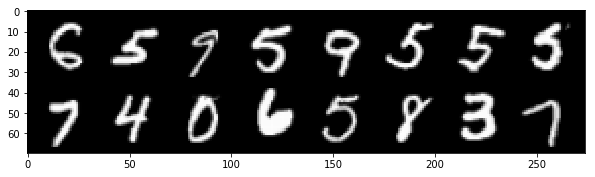

In [11]:
loader = load_data(16)

fig = plt.figure(figsize = (10,5))
for batch in loader:
    grid_plot = make_grid(batch[0], normalize=True)
    plt.imshow(np.transpose(grid_plot.numpy(), (1,2,0)))
    break

In [12]:
!rm -rf logs
%tensorboard --logdir logs/

In [0]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.ConvTranspose2d or type(m) == nn.Conv2d:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        
def noise(size):
    return Variable(torch.randn((size, z_size)).view(-1, z_size, 1, 1).to(device))
  

# Creates one hot encoding for generator batch
one_hot_base_gen = torch.eye(targets_size)
def one_hot_gen(labels):
    return Variable(torch.index_select(one_hot_base_gen, 0, labels).view(-1, targets_size, 1, 1).to(device))

# Creates one hot encoding for discriminator batch
one_hot_base_dis = torch.zeros([10, 10, img_size, img_size])
for i in range(10):
    one_hot_base_dis[i, i, :, :] = 1
def one_hot_dis(labels):
    return Variable(torch.index_select(one_hot_base_dis, 0, labels).to(device))

In [0]:
if img_size == 64:
    discriminator = Discriminator().to(device)
    generator = Generator().to(device)
elif img_size == 32:
    discriminator = Discriminator_32().to(device)
    generator = Generator_32().to(device)
else:
    discriminator = None
    generator = None
    
discriminator.apply(init_weights)
generator.apply(init_weights)

d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(betas1, 0.999))
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(betas1, 0.999))
loss = nn.BCELoss()

In [15]:
num_epochs = 25
batch_size = 128

test_noise = noise(16)
test_targets = torch.randint(0, targets_size, (16,))
print(test_targets.numpy())

train_loader = load_data(batch_size)
writer = SummaryWriter('logs/')
iterations_gen = 0

for epoch in range(num_epochs):
    d_loss_epoch = 0
    g_loss_epoch = 0
    iterations = 0

    for n_batch, batch in enumerate(train_loader):
        # Train discriminator, maximize log(D(x)) + log(1-D(G(x)))
        # 1) Use real data
        real_data = Variable(batch[0].to(device))
        real_labels = Variable(torch.ones(batch[0].size(0)).to(device))
        real_one_hot = one_hot_dis(batch[1])
        d_real_output = discriminator(real_data, real_one_hot).squeeze()
        d_real_loss = loss(d_real_output, real_labels)
        # 2) Use fake data
        fake_targets = torch.randint(0, targets_size, (batch[0].size(0),))
        fake_data = generator(noise(batch[0].size(0)), one_hot_gen(fake_targets)).detach()
        fake_labels = Variable(torch.zeros(batch[0].size(0)).to(device))
        d_fake_output = discriminator(fake_data, one_hot_dis(fake_targets)).squeeze()
        d_fake_loss = loss(d_fake_output, fake_labels)
        # Backpropagation
        d_optimizer.zero_grad()
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        # Train generator, minimize log(1-D(G(x))) = maximize log(D(G(x)))
        g_targets = torch.randint(0, targets_size, (batch[0].size(0),))
        g_output = generator(noise(batch[0].size(0)), one_hot_gen(g_targets))
        d_output = discriminator(g_output, one_hot_dis(g_targets)).squeeze()
        g_loss = loss(d_output, real_labels)
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
        d_loss_epoch += d_loss.item()
        g_loss_epoch += g_loss.item()

        if n_batch%50 == 0:
            print('\rEpoch [%d/%d], Batch [%d/%d]' % (epoch+1, num_epochs, (iterations_gen*50)%len(train_loader), len(train_loader)), end='')
            
            generator.eval()
            with torch.no_grad():
                test_gen = generator(test_noise, one_hot_gen(test_targets))
            generator.train()
            
            writer.add_image('test_gen', make_grid(test_gen, normalize=True), iterations_gen)
            writer.add_scalar('d_loss_batch', d_loss, iterations_gen)
            writer.add_scalar('g_loss_batch', g_loss, iterations_gen)
            iterations_gen += 1
        iterations += 1  
        
    writer.add_scalar('d_loss_epoch', d_loss_epoch/(iterations*2), epoch)
    writer.add_scalar('g_loss_epoch', g_loss_epoch/iterations, epoch)

[7 3 7 3 7 6 4 5 6 2 5 4 7 9 5 9]
Epoch [25/25], Batch [256/469]

In [0]:
# Save model to Google Drive
import time
timestr = time.strftime("%d%m%Y-%H%M%S")
torch.save(generator.state_dict(), 'gdrive/My Drive/models/cDCGAN_gen'+timestr+'.pt')
torch.save(discriminator.state_dict(), 'gdrive/My Drive/models/cDCGAN_dis'+timestr+'.pt')

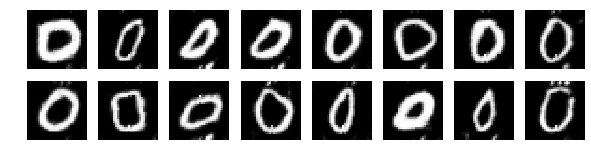

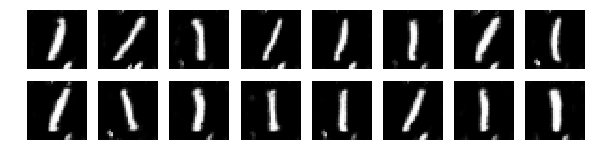

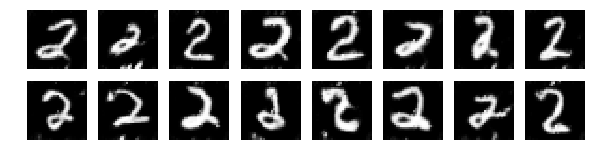

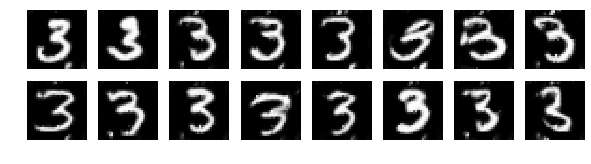

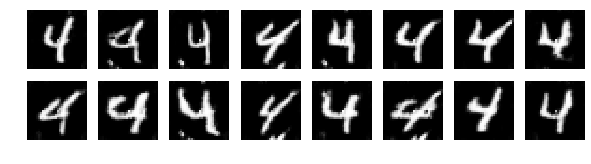

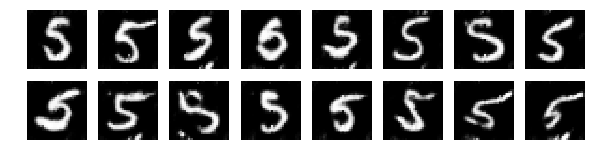

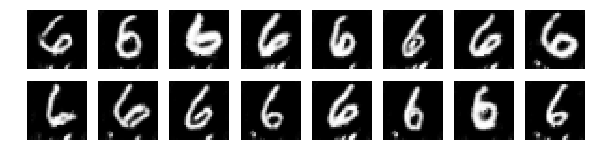

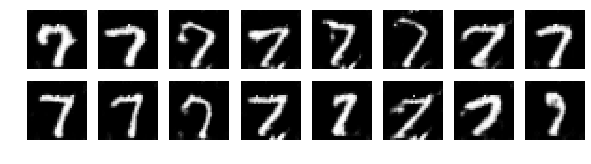

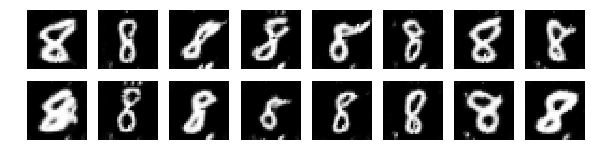

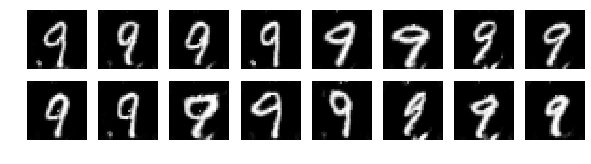

In [17]:
%matplotlib inline
for i in range(10):
    num_test = 16
    target = one_hot_gen(torch.LongTensor(16).fill_(i))
    generator.eval()
    with torch.no_grad():
        test = np.squeeze(np.transpose(generator(noise(num_test), target).cpu().data.numpy(), (0,2,3,1)))
    test = test*0.5 + 0.5
    fig = plt.figure(figsize = (10,5))
    for i in range(num_test):
        fig.add_subplot(4,8,i+1)
        plt.axis('off')
        plt.imshow(test[i], cmap='gray', interpolation='nearest')